In [1]:
# Imports
import spotipy
from spotipy import util
from spotipy import oauth2
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
from os import path
import datetime as dt
import time

In [2]:
# A class to manage all of the storm functions and authentication
class Storm:
    
    def __init__(self, scope, user_id, client_id, client_secret, inputs, output, archive, name, start_date=None):
        
        # Variables
        self.scope = scope
        self.user_id = user_id
        self.client_id = client_id
        self.client_secret = client_secret
        self.token = None
        self.token_start = None
        self.sp = None
        self.inputs = inputs
        self.output = output
        self.archive = archive
        self.name = name
        self.start_date = start_date
        self.window_date = None
        
        # Initialization
        self.authenticate()
        self.gen_dates()
        
        # I/O Params
        self.artist_id_csv = 'storm_artists_'+self.name+'.csv'
        self.album_id_csv = 'storm_albums_'+self.name+'.csv'
        self.md_name = 'storm_run_metadata_'+self.name+'.csv'
        
        # Dataframe init
        self.blacklist = []
        self.artist_ids = []
        self.album_ids = []
        self.albums = pd.DataFrame(columns = ['album_group', 'album_type', 'artists', 'available_markets',
                               'external_urls', 'href', 'id', 'images', 'name', 'release_date',
                               'release_date_precision', 'total_tracks', 'type', 'uri'])
        self.new_ablums = pd.DataFrame()
        self.new_tracks = pd.DataFrame(columns = ['artists', 'available_markets', 'disc_number', 'duration_ms',
                               'explicit', 'external_urls', 'href', 'id', 'is_local', 'name',
                               'preview_url', 'track_number', 'type', 'uri'])
        self.storm_track_ids = []
        
        
        # Interesting Metadata
        self.mdf = pd.read_csv(self.md_name).set_index('run_date')
        self.rd = dt.datetime.now().strftime("%Y/%m/%d")
        self.mdf.loc[self.rd, 'start_date'] = self.start_date
        
            
    # Authentication Functions
    def authenticate(self):
        
        print("Generating Token and Authenticating. . .")
        self.token = util.prompt_for_user_token(self.user_id,
                                                scope=self.scope,
                                                client_id=self.client_id,
                                                client_secret=self.client_secret,
                                                redirect_uri='http://localhost/')
        self.sp = spotipy.Spotify(auth=self.token)
        self.token_start = dt.datetime.now()
        print("Authentication Complete.")
        print()
    
    def check_token(self):
        
        if abs((self.token_start - dt.datetime.now()).total_seconds()) < 3580:
            return True
        else:
            print("Awaiting Expiration and Refreshing.")
            time.sleep(25)
            self.authenticate()

    def gen_dates(self):
        
        # Start Dates
        if self.start_date == None:
            self.start_date = (dt.datetime.now() - dt.timedelta(days=2)).strftime("%Y-%m-%d")
            
        # Playlist Cycling dates
        self.window_date = (dt.datetime.now() - dt.timedelta(days=14)).strftime("%Y-%m-%d")
     
    
    # Ochestration Function
    def Run(self):
        
        # Read-in existing data from past runs
        self.read_in()
        
        # Augment artist list before track collection
        self.augment_artist_list()
        self.clean_artists()
        self.save_artists()
        
        # Get Album lists
        self.get_artist_albums()
        self.filter_albums()
        
        # Tracks
        self.get_album_tracks()
        self.clean_tracks()
        
        # Playlist Writing
        self.archive_current()
        self.add_tracks_to_playlist(self.output, self.storm_track_ids)
        
        # Metadata save
        self.save_md()
        self.save_albums()
        
    
    # I/O
    def read_in(self):
        
        print("Reading in existing Data.")
        
        if path.exists(self.artist_id_csv):
            print("Storm Arists Found! Reading in now.")
            self.artist_ids = pd.read_csv(self.artist_id_csv)['artists'].values.tolist()
            self.mdf.loc[self.rd, 'artists_tracked'] = len(self.artist_ids)
            print(f"Done! {len(self.artist_ids)} Unique Artists found.")
            
        else:
            self.mdf.loc[self.rd, 'artists_tracked'] = 0
        print()
            
        if path.exists('storm_blacklist_'+self.name+'.csv'):
            print("Blacklisted Arists Found! Reading in now.")
            self.blacklist = pd.read_csv('storm_blacklist_'+self.name+'.csv')['artists'].tolist()
            self.mdf.loc[self.rd, 'blacklisted_artists'] = len(self.blacklist)
            print(f"Done! {len(self.blacklist)} Blacklisted Artists found.")
        print()
            
        if path.exists(self.album_id_csv):
            print("Previously Discovered Albums Found! Reading in now.")
            self.album_ids = pd.read_csv(self.album_id_csv)['albums'].values.tolist()
            self.mdf.loc[self.rd, 'albums_tracked'] = len(self.album_ids)
            print(f"Done! {len(self.album_ids)} Albums found.") 
            
        else:
            self.mdf.loc[self.rd, 'albums_tracked'] = 0
        print()
    
    def save_artists(self):
        
        print("Saving Artist Ids.")
        pd.DataFrame(self.artist_ids, columns=['artists']).to_csv(self.artist_id_csv, index=False)
    
    def save_albums(self):
        print("Saving Albums from run.")
        self.album_ids = self.albums.id.tolist()
        pd.DataFrame(self.album_ids, columns=['albums']).to_csv(self.album_id_csv, index=False)
    
    def save_md(self):
        
        print("Writing metadata from run.")
        self.mdf.to_csv(self.md_name)
    
    
    # Storm Aggregate Functions
    def augment_artist_list(self):
         
        # Comb through playlists and get the artist ids
        print("Augmenting new Artists from playlist input dictionary.")
        for pl in self.inputs.keys():
            print("Obtaining a list of Tracks from Playlist . . ." + pl)
            playlist_df = self.get_playlist_tracks(self.inputs[pl])

            print("Finding Artists . . .")
            self.extend_artists(playlist_df['track'])
        
        print("Done! All Input Playlists Scanned.")

    def get_playlist_tracks(self, playlist_id):
        
        lim = 50
        more_tracks = True
        offset=0

        self.check_token()
        playlist_results = self.sp.user_playlist_tracks(self.user_id, playlist_id, limit=lim, offset=offset)
        
        if len(playlist_results['items']) < lim:
                more_tracks = False

        while more_tracks:

            self.check_token()
            offset += lim
            batch = self.sp.user_playlist_tracks(self.user_id, playlist_id, limit=lim, offset=offset)
            playlist_results['items'].extend(batch['items'])

            if len(batch['items']) < lim:
                more_tracks = False

        response_df = pd.DataFrame(playlist_results['items'])
        return response_df
    
    def extend_artists(self, track_df):

        new_artists = []
        for track in track_df:
            try:
                artists = dict(track)['artists']
            except:
                continue

            for artist in artists:
                if artist['id'] not in self.artist_ids:
                    self.check_token()
                    artist_info = self.sp.artist(artist['id'])
                    if 'classical' not in artist_info['genres']:
                        self.artist_ids.append(artist['id'])
    
    def clean_artists(self):

        print("Removing Blacklist Artists.")
        self.filter_blacklist()
    
    def clean_tracks(self):
        
        self.storm_track_ids = np.unique(self.storm_track_ids)
        self.new_tracks = self.new_tracks.drop_duplicates('id').reset_index(drop=True)
        newids = []
        for index in self.new_tracks.index:
            
            artists = self.new_tracks.loc[index, 'artists']
            check=True
            for artist in artists:
                if artist['id'] in self.blacklist:
                     check = False
            if check:
                 newids.append(self.new_tracks.loc[index, 'id'])
        self.storm_track_ids = newids
        self.mdf.loc[self.rd, 'tracks_added'] = len(self.storm_track_ids)
        self.mdf.loc[self.rd, 'tracks_removed'] = self.mdf.loc[self.rd, 'tracks_eligible'] - self.mdf.loc[self.rd, 'tracks_added']
    
    def filter_classical(self):

        output_list = []
        for artist in tqdm(self.artist_ids):
            self.check_token()
            artist_info = self.sp.artist(artist)

            if 'classical' not in artist_info['genres']:
                output_list.append(artist)

        self.artist_ids = output_list
        
    def filter_blacklist(self):

        output_list = []
        for artist in tqdm(self.artist_ids):
            if artist not in self.blacklist:
                output_list.append(artist)

        self.artist_ids = output_list
        self.mdf.loc[self.rd, 'artists_augmented'] = len(self.artist_ids)-self.mdf.loc[self.rd, 'artists_tracked']
    
    def get_artist_albums(self):
        
        print("Obtaining all albums from the list of artists. (Albums)")
        lim = 50
        for artist_id in tqdm(self.artist_ids):
            
            self.check_token()
            response = self.sp.artist_albums(artist_id, limit=lim, album_type='album')
            offset = 0
            more_albums = True

            while more_albums:
                
                self.check_token()
                batch = self.sp.artist_albums(artist_id, limit=lim, offset=offset, album_type='album')
                response['items'].extend(batch['items'])
                offset += lim

                if len(batch['items']) < lim:
                        more_albums = False

            response_df = pd.DataFrame(response['items'])
            self.albums = pd.concat([self.albums, response_df], axis=0)
           
        print(f"Albums being tracked: {len(self.albums)}")
        print("Obtaining all albums from the list of artists. (Singles)")
        for artist_id in tqdm(self.artist_ids):
            
            self.check_token()
            response = self.sp.artist_albums(artist_id, limit=lim, album_type='single')
            offset = 0
            more_albums = True

            while more_albums:
                
                self.check_token()
                batch = self.sp.artist_albums(artist_id, limit=lim, offset=offset, album_type='single')
                response['items'].extend(batch['items'])
                offset += lim

                if len(batch['items']) < lim:
                        more_albums = False

            response_df = pd.DataFrame(response['items'])
            response_df = response_df
            self.albums = pd.concat([self.albums, response_df], axis=0)
            
        print(f"Albums being tracked: {len(self.albums)}")
   
    def filter_albums(self):
        
        # Or Condition, either its new or hasn't been viewed
        print("Filtering Album list for new content.")
        self.new_albums = self.albums[~self.albums.id.isin(self.album_ids)]
        self.mdf.loc[self.rd, 'albums_augmented'] = len(self.new_albums)
          
    def get_album_tracks(self):
        
        lim = 50
        print("Using Filtered albums to obtain a track list.")
        for album_id in tqdm(self.new_albums.id):
            self.check_token()
            response = self.sp.album_tracks(album_id, limit=lim)
            offset = 0
            more_tracks = True
            if len(response['items']) < lim:
                    more_tracks = False

            while more_tracks:
                
                self.check_token()
                batch = self.sp.album_tracks(album_id, limit=lim, offset=offset)
                response['items'].extend(batch['items'])
                offset += lim

                if len(batch['items']) < lim:
                    more_tracks = False

            response_df = pd.DataFrame(response['items'])
            self.new_tracks = pd.concat([self.new_tracks, response_df], axis=0)
        self.mdf.loc[self.rd, 'tracks_eligible'] = len(self.new_tracks)
    
    def archive_current(self):
        
        # Read-in current tracks
        print("Archiving Current Storm Listening.")
        current_listening = self.get_playlist_tracks(self.output)
        current_archive = self.get_playlist_tracks(self.archive)
        
        try:
            track_ids_cur = [dict(track)['id'] for track in current_listening.track]
            track_ids_arc = [dict(track)['id'] for track in current_archive.track]
            track_ids_writing = []

            for track in track_ids_cur:
                if track not in track_ids_arc:
                    track_ids_writing.append(track)

            # Write them to the archive playlist
            if len(track_ids_writing) == 0:
                print("No Unique tracks to Archive.")
            else:
                self.add_tracks_to_playlist(self.archive, track_ids_writing, replace=False)
        except:
            print("No Tracks to Archive.")
    
    def add_tracks_to_playlist(self, playlist_id, track_ids, replace=True):
        
        print("Preparing Tracks for Writing")
        lim = 50
        if len(self.storm_track_ids) > lim:
            split_tracks = np.array_split(track_ids, np.ceil(len(track_ids)/lim))

            print("Writing Tracks")
            if replace:
                self.check_token()
                self.sp.user_playlist_replace_tracks(self.user_id, playlist_id, split_tracks[0])
                for track_list in tqdm(split_tracks[1:]):
                    self.check_token()
                    self.sp.user_playlist_add_tracks(self.user_id, playlist_id, track_list)
            else:
                for track_list in tqdm(split_tracks):
                    self.check_token()
                    self.sp.user_playlist_add_tracks(self.user_id, playlist_id, track_list)
        else:
            print("Writing Tracks")
            if replace:
                self.check_token()
                self.sp.user_playlist_replace_tracks(self.user_id, playlist_id, self.storm_track_ids)
            else:
                self.check_token()
                self.sp.user_playlist_add_tracks(self.user_id, playlist_id, self.storm_track_ids)

In [3]:
# Shared Variables and Functions
sc = 'user-follow-read playlist-modify-private playlist-modify-public user-follow-modify'
user = '1241528689'
cid = '9b41900f606c4e55855524f448917d64'
secret = '3277c16b708548369ce1f42deed974ea'

# Playlist Inputs
output_playlist = {'daily':'7fnvajjUoWBQDo8iFNMH3s',
                   'archive':'1Q8WS7Xj51WCHZctXGDsrp'}

# Inputs
inputs = {'Much Needed':'7N3pwZE1N38wcdiuLxiPvq',
                  'Room on the Boat':'1SZS16UcW0XOzgh6UWXA9S',
                  'Refuge':'3K9no6AflSDYiiMzignAm7',
                  'Safety':'0R1gw1JbcOFD0r8IzrbtYP',
                  'Shelter from the Storm':'2yueH0i9C2daBRawYIc9P8',
                  'Soundtracked':'37i9dQZF1DWW7gj0FcGEx6',
                  'Refuge':'3K9no6AflSDYiiMzignAm7',
                  'Soundtrack for Study':'0hZNf3tcMT4x03FyjKYJ3M',
                  'Film Music - Movie Scores':'5GhatXsZVNYxrhqEAfZPLR',
                  'Video Game Music':'37i9dQZF1DXdfOcg1fm0VG',
                  'Video Game Soundtracks':'3Iwd2RiXCzmm1AMUpRAaHO',
                  'Video Game Music Unofficial':'3aI7ztMmDhMHhYe1KOPFLG',
                  'Fantasy - Music Writing':'0zjGLygoBmpafEsGtk5n1a',
                  'OST Game Playlist':'3Iwd2RiXCzmm1AMUpRAaHO'}

In [4]:
# Authorized spotipy object
storm = Storm(sc, user, cid, secret, inputs, 
              output_playlist['daily'], output_playlist['archive'], 'instrumental')#, start_date='2020-05-23')

storm.Run()

Generating Token and Authenticating. . .
Authentication Complete.

Reading in existing Data.
Storm Arists Found! Reading in now.
Done! 1388 Unique Artists found.

Blacklisted Arists Found! Reading in now.
Done! 192 Blacklisted Artists found.

Previously Discovered Albums Found! Reading in now.
Done! 55135 Albums found.

Augmenting new Artists from playlist input dictionary.
Obtaining a list of Tracks from Playlist . . .Much Needed
Finding Artists . . .
Obtaining a list of Tracks from Playlist . . .Room on the Boat
Finding Artists . . .
Obtaining a list of Tracks from Playlist . . .Refuge
Finding Artists . . .
Obtaining a list of Tracks from Playlist . . .Safety
Finding Artists . . .
Obtaining a list of Tracks from Playlist . . .Shelter from the Storm
Finding Artists . . .
Obtaining a list of Tracks from Playlist . . .Soundtracked
Finding Artists . . .
Obtaining a list of Tracks from Playlist . . .Soundtrack for Study
Finding Artists . . .
Obtaining a list of Tracks from Playlist . . .F


Saving Artist Ids.
Obtaining all albums from the list of artists. (Albums)



Albums being tracked: 33853
Obtaining all albums from the list of artists. (Singles)


retrying ...1secs

Albums being tracked: 55425
Filtering Album list for new content.
Using Filtered albums to obtain a track list.



Archiving Current Storm Listening.
Preparing Tracks for Writing
Writing Tracks



Preparing Tracks for Writing
Writing Tracks



Writing metadata from run.
Saving Albums from run.


In [5]:
# Plots and Processing
df = storm.mdf

df['track_added_sum'] = df.tracks_added.cumsum()
df['track_elig_sum'] = df.tracks_eligible.cumsum()

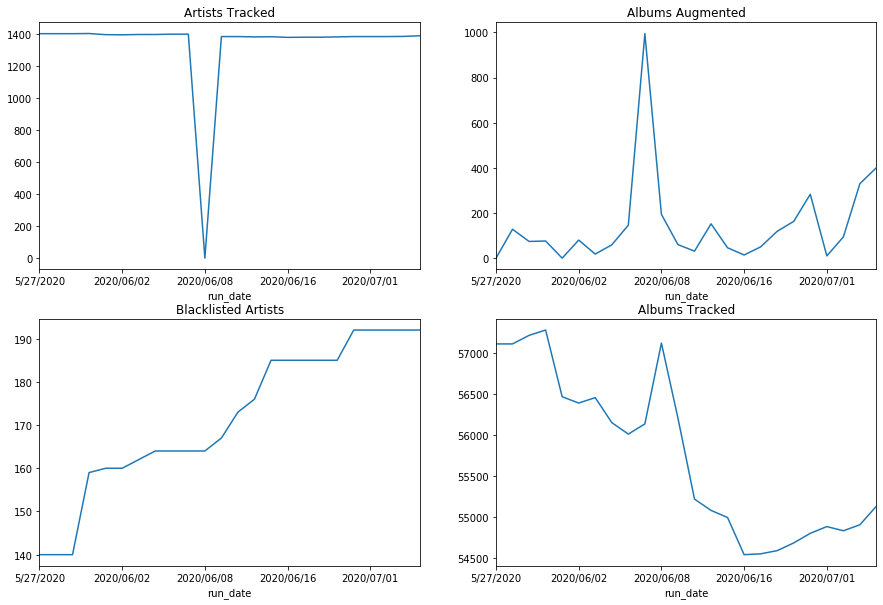

In [6]:
fig, ax = plt.subplots(2, 2, figsize = (15, 10));
df.artists_tracked.plot(ax=ax[0][0]).set_title("Artists Tracked");
df.blacklisted_artists.plot(ax=ax[1][0]).set_title("Blacklisted Artists");
df.albums_augmented.plot(ax=ax[0][1]).set_title("Albums Augmented");
df.albums_tracked.plot(ax=ax[1][1]).set_title("Albums Tracked");

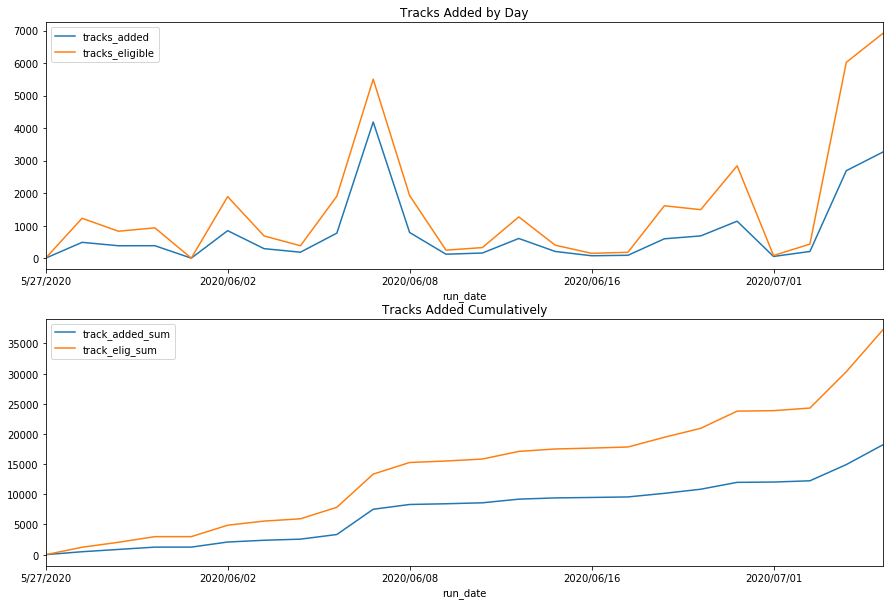

In [7]:
fig, ax = plt.subplots(2, 1, figsize=(15, 10));
df[['tracks_added', 'tracks_eligible']].plot(ax=ax[0]).set_title('Tracks Added by Day');
df[['track_added_sum', 'track_elig_sum']].plot(ax=ax[1]).set_title('Tracks Added Cumulatively');